# Make the MPNN Model
We are going to layers from the [NFP](https://github.com/NREL/nfp) package from NREL to build out MPNN model.

NFP is built using Tensorflow. So, we will need to make a data loader that will generate TF-compatible data and a Keras Model object.
We use `tf.keras` for all operations to keep simple compatibility with TF2.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.mpnn.data import make_data_loader
from hydronet.mpnn.layers import GraphNetwork, Squeeze, build_fn
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tqdm import tqdm
import tensorflow as tf
import pickle as pkl
import numpy as np
import gzip
import json
import os

Configurationbuild_fn

In [2]:
data_file = os.path.join('..', 'data', 'output', 'coarse_train.proto')

## Assemble Iterator
Make an iterator over the dataset that will generate batches of networks with each batch collapsed to a single "supernetwork"

In [3]:
r = make_data_loader(data_file, shuffle_buffer=32768, batch_size=256)

Get an example batch

In [4]:
batch = next(iter(r))

We are not going to be saving the data loader. We'll remake it during the actual training procedure.

For now, we are using it for testing purposes.

See how random the batches are

In [5]:
batches = [b for b, _ in zip(r, tqdm(range(256)))]

100%|██████████| 256/256 [00:00<00:00, 393.46it/s]


Plot the changes in the mean number of atoms

<ErrorbarContainer object of 3 artists>

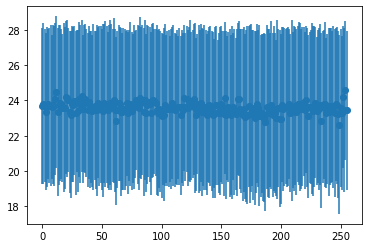

In [6]:
fig, ax = plt.subplots()

ax.errorbar(
    range(len(batches)),
    [b[0]['n_atom'].numpy().mean() for b in batches],
    fmt='o',
    yerr=[b[0]['n_atom'].numpy().std() for b in batches],
)

## Make the Model
Create the Keras Model object that describes the neural network.

Compute the atomic energy

In [7]:
atomic_energy = (batch[1].numpy()[:, 0] / batch[0]['n_atom'].numpy()).mean()
print(f'Average energy per water: {atomic_energy}')

Average energy per water: -10.520100056495238


In [8]:
network = build_fn(atomic_energy)

Print out the performance without any training

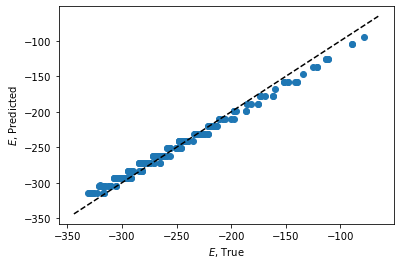

In [9]:
fig, ax = plt.subplots()

pred_y = network.predict_on_batch(batch[0])
ax.scatter(batch[1], pred_y)

ax.set_ylabel('$E$, Predicted')
ax.set_xlabel('$E$, True')

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')